# Topic modelling of Welsh Government announcements 

This notebook contains Python code for text pre-processing, topic modelling with Latent Dirichlet Allocation, and plotting the top 5 words per topic. 

In [56]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize.casual import casual_tokenize
from nltk.corpus import stopwords
import pandas as pd
import numpy as np

In [57]:
web_data = pd.read_csv("sample-datasets/data_2020-10-05.csv")

stop_words = stopwords.words('english')

cleanup_words = ["pdf", "xlsx", "email", "gov.wales", "kb", "accessible", "format", "interactive", "tools", "telephone", "website", "wales", "welsh", "twitter", "facebook", 
                   "if you need a more accessible version of this document please email",
                   "file type", "file size",
                   "if you use assistive technology please tell us what this is",
                   "html", "share", "page"]

prep_data = web_data[web_data['category'] == "Ministerial Announcements"]
prep_data['text'] = prep_data['text'].str.lower()
prep_data['text'] = prep_data['text'].str.replace('[0-9]+', '')
prep_data['text'] = prep_data['text'].str.replace('|'.join(cleanup_words), '')
prep_data['text'] = prep_data['text'].str.replace('[^\w\s]','')
prep_data['text'] = prep_data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

<ipython-input-57-c621ccd0a155>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_data['text'] = prep_data['text'].str.lower()
<ipython-input-57-c621ccd0a155>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  prep_data['text'] = prep_data['text'].str.replace('[0-9]+', '')
<ipython-input-57-c621ccd0a155>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prep_data['text'] = prep_data['text'].str.replace('[0-9]+', '')
<ipython-input-57-c621ccd0a155>:14: Fu

In [58]:
counter = CountVectorizer(tokenizer=casual_tokenize)
bow_docs = pd.DataFrame(counter.fit_transform(raw_documents=prep_data.text)\
                       .toarray())
column_nums, terms = zip(*sorted(zip(counter.vocabulary_.values(),\
                                    counter.vocabulary_.keys())))
bow_docs.columns = terms

In [61]:
np.random.seed(100)
all_text_lda = LDA(n_components = 20, learning_method = 'batch', max_iter = 30)
all_text_lda = all_text_lda.fit(bow_docs)
normalized_components = all_text_lda.components_ / all_text_lda.components_.sum(axis=1)[:, np.newaxis]
components = pd.DataFrame(normalized_components.T, index = terms, columns=['topic {}'.format(i) for i in range(1, 21)])
# Get transpose of matrix
topic_word = components.T
topic_word['topic_number'] = topic_word.index
topic_word = topic_word.melt(id_vars = ['topic_number'], var_name = 'term')
ldia_top_5_words = topic_word.sort_values(by = ['topic_number', 'value'], ascending=False).groupby('topic_number').head(5)

<ipython-input-61-5a2cbe1c1dd2>:9: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  topic_word = topic_word.melt(id_vars = ['topic_number'], var_name = 'term')


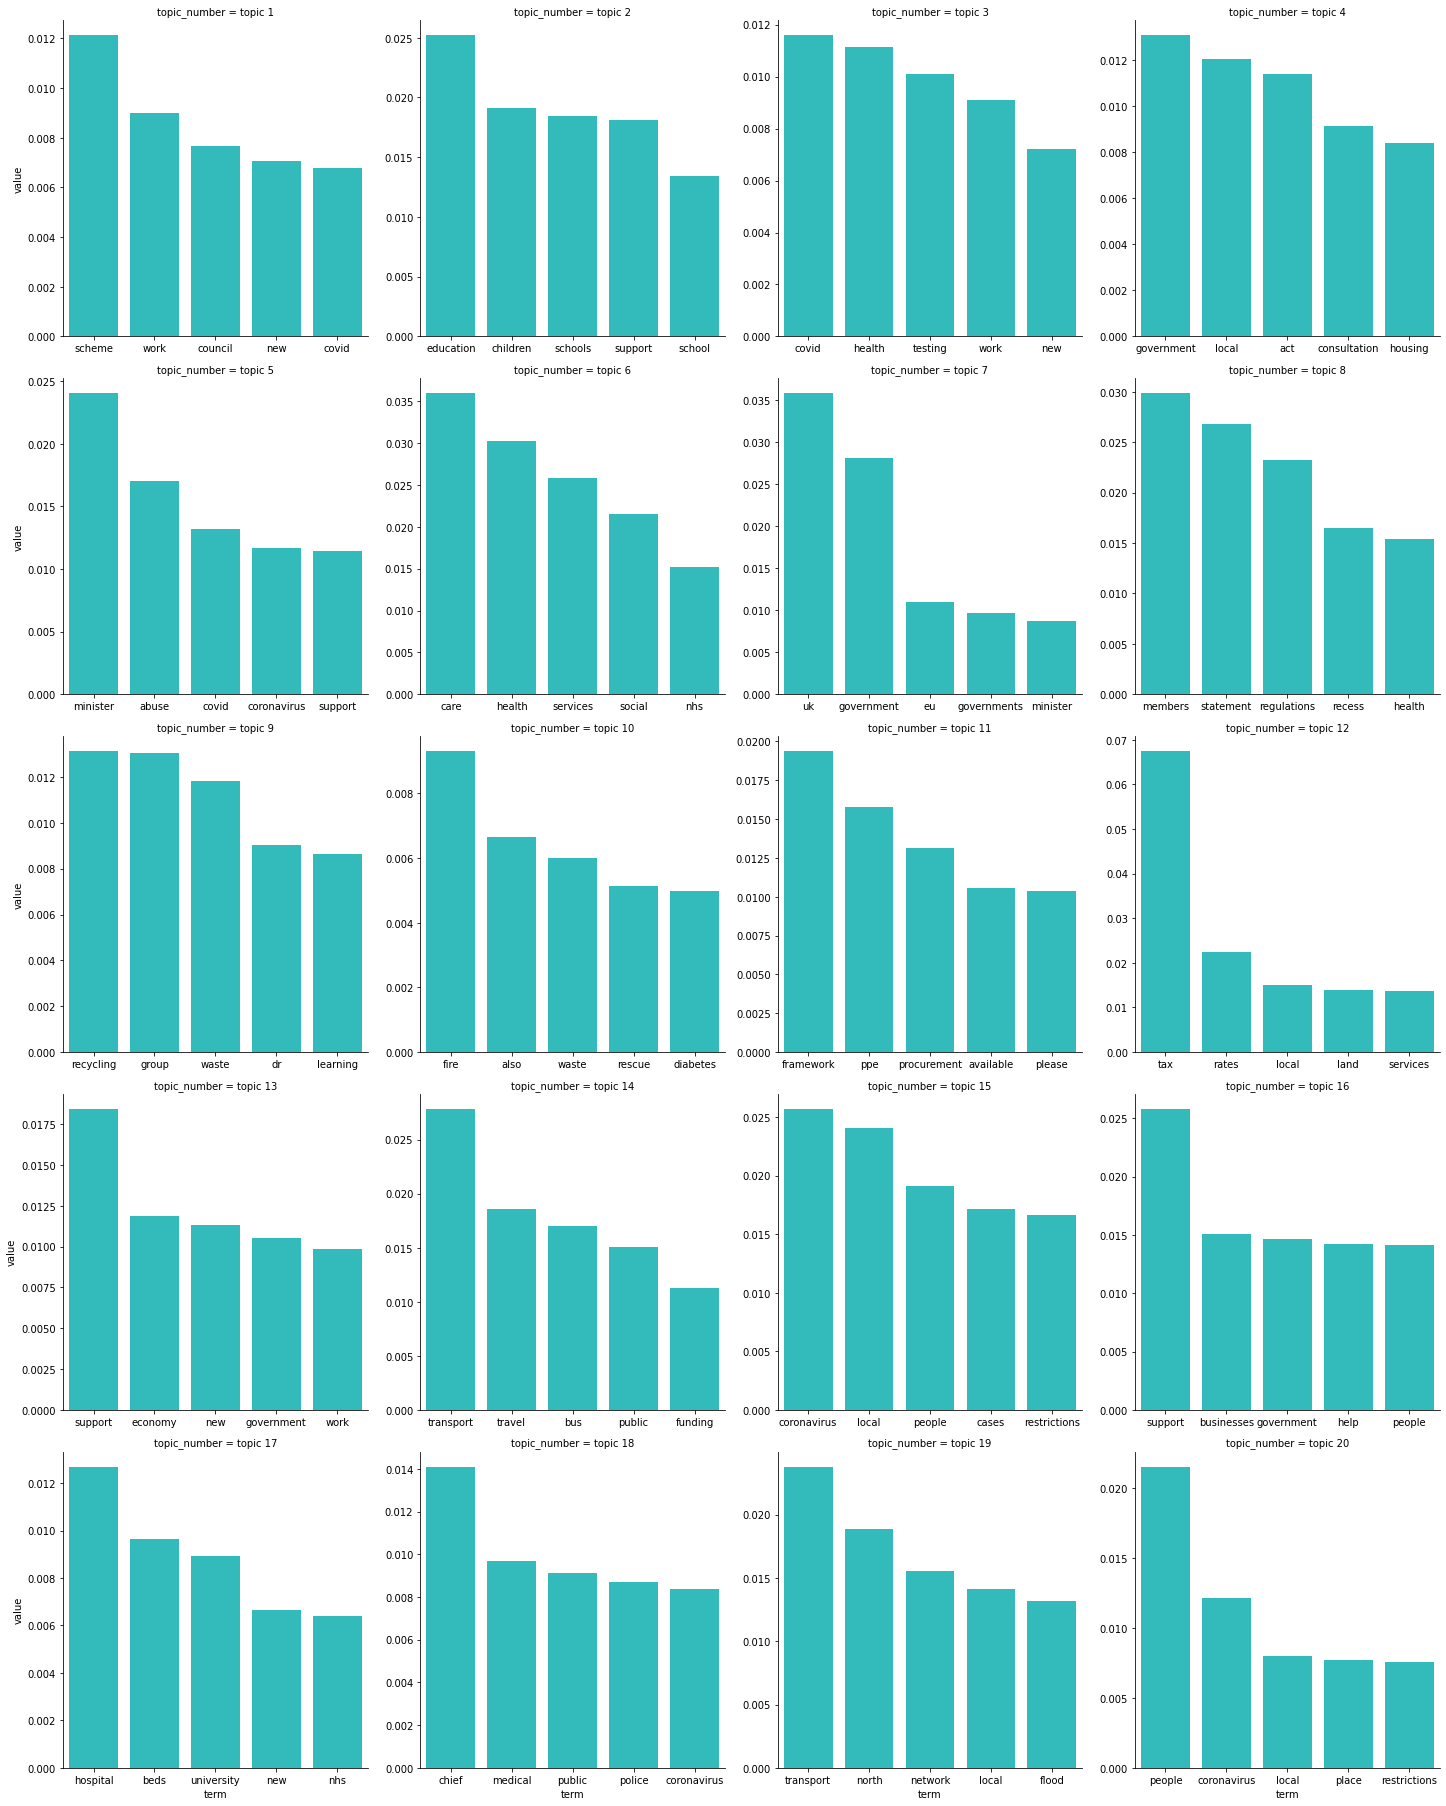

In [62]:
import seaborn as sns

topic_order = ["topic " + str(x) for x in range(1, 21)]

sns.catplot(x = "term", y = "value", col = "topic_number",
           kind = "bar", col_wrap = 4, sharey = False, sharex = False,
           col_order = topic_order, color = "#1CD1D2", data = ldia_top_5_words)